# Finetune CLIP


## Useful Package
* torch
* huggingface
* numpy, pandas, matplotlib

In [ ]:
!pip install torchinfo
!pip install torchmetrics
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
import os
import time
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchmetrics.classification import Accuracy, AUROC
from transformers import (
    CLIPProcessor, CLIPTokenizer,
    CLIPVisionModelWithProjection,
    CLIPTextModelWithProjection,
    get_scheduler
)

## Reproducibilty
* python random
* torch random
* GPU random

In [ ]:
MYSEED = 2024
np.random.seed(MYSEED)
torch.manual_seed(MYSEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Colab Setting
* 掛載路徑
* 轉換路徑到資料集底下

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/大專生計畫

/content/gdrive/MyDrive/大專生計畫


## 資料集格式
* torch dataset 封裝
    * \_\_init\_\_
    * \_\_getitem\_\_
    * \_\_len\_\_
* 資料處理與向量化
    * 定義 collator
    * CLIP 的文字與圖片處理器
    * [SEP] 串接迷音文字與圖片摘要

In [ ]:
class HatefulMemeDataset(Dataset):
    def __init__(self, df, image_size=224, entry="data"):
        self.image_paths = [
            os.path.join(entry, path) for path in df["img"]
        ]
        self.image_size = image_size
        self.captions = list(df["caption"])
        self.meme_texts = list(df["text"])
        self.labels = list(df["label"])
        self.ids = list(df["id"])

    def __getitem__(self, index: int):
        item = {
            "image": Image.open(self.image_paths[index]).convert('RGB').resize(
                (self.image_size, self.image_size)
            ),
            "text": self.meme_texts[index],
            "caption": self.captions[index],
            "label": self.labels[index],
            "id": self.ids[index]
        }
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
class MemeCollator(object):

    def __init__(self, image_processor, text_processor):
        self.image_processor = image_processor
        self.text_processor = text_processor

    def __call__(self, batch):
        new_batch = dict()
        # encode image
        new_batch["pixel_values"] = self.image_processor(
            images=[item['image'] for item in batch],
            return_tensors="pt"
        )['pixel_values']

        # encode text and caption
        # add [SEP] between them
        text_output = self.text_processor(
            [item['text'] for item in batch],
            padding=True, truncation=True,
            return_tensors="pt"
        )
        new_batch["input_ids"] = text_output["input_ids"]
        new_batch['attention_mask'] = text_output['attention_mask']
        new_batch["label"] = torch.LongTensor([item["label"] for item in batch])
        # id is used to trace the correct/incorrect sample
        new_batch["id"] = torch.LongTensor([item["id"] for item in batch])

        return new_batch

## Utility function

* 索取 dataloader 第一個 batch
* 將訓練或驗證結果寫入log
* 從 log 讀出訓練或驗證結果

In [ ]:
def get_batch_data(dataloader):
    for batch in dataloader:
        return batch

In [ ]:
def write_log(data: dict, train: bool=True, need_print: bool=True, filename: str=""):

    if need_print:
        # print out result
        print(f"===> loss: {data['loss']:.4f}, acc: {data['acc']:.2f},  auroc: {data['auroc']:.2f}")

    if len(filename) != 0:
        # write result to csv
        if os.path.exists(filename):
            # append new result
            with open(filename, "a") as f:
                line = f"{data['epoch']}\t{data['loss']:.4f}\t{data['acc']:.2f}\t{data['auroc']:.2f}"
                f.write(line)
                f.write("\n")
        else:
            # create the title
            # and append new result
            with open(filename, "w") as f:
                line = "\t".join([k.capitalize() for k in data.keys()])
                f.write(line)
                f.write("\n")
                line = f"{data['epoch']}\t{data['loss']:.4f}\t{data['acc']:.2f}\t{data['auroc']:.2f}"
                f.write(line)
                f.write("\n")

In [ ]:
def read_log(filename: str) -> tuple:
    train_data = dict()
    eval_data = dict()
    column_names = []
    if not os.path.exists(filename):
        # error => no that file
        print("No such File!!!")
    else:
        with open(filename, "r") as f:
            for i, line in enumerate(f.readlines()):
                if i != 0:
                    line = line.split("\t")
                    if i % 2 == 1:
                        # read the training
                        train_data[column_names[0]].append(int(line[0]))
                        for i in range(1, len(line)):
                            train_data[column_names[i]].append(float(line[i]))
                    else:
                        # read the evaluating
                        eval_data[column_names[0]].append(int(line[0]))
                        for i in range(1, len(line)):
                            eval_data[column_names[i]].append(float(line[i]))
                else:
                    # pass the column name
                    line = line.rstrip("\n")
                    line = line.split("\t")
                    for column_name in line:
                        column_name = column_name.lower()
                        column_names.append(column_name)
                        train_data[column_name] = []
                        eval_data[column_name] = []


    return train_data, eval_data

## 模型建構
使用 CLIP 多模態模型當作視覺和文字的 encoder，額外加入projection layer 將 encoded vector 投影到相同維度後融合特徵。

In [ ]:
class HateCliper(nn.Module):

    def __init__(self, **args):
        super().__init__()
        self.image_encoder = CLIPVisionModelWithProjection.from_pretrained(args["model_name"])
        self.text_encoder = CLIPTextModelWithProjection.from_pretrained(args["model_name"])

        # freeze the clip model
        for name, param in self.image_encoder.named_parameters():
            param.requires_grad = False
        for name, param in self.text_encoder.named_parameters():
            param.requires_grad = False

        self.image_proj = nn.Sequential(
            nn.ReLU(),
            nn.Linear(self.image_encoder.config.projection_dim, args["proj_dim"])
        )
        self.text_proj = nn.Sequential(
            nn.ReLU(),
            nn.Linear(self.text_encoder.config.projection_dim, args["proj_dim"])
        )

        self.fusion_method = args["fusion_method"]
        # set flatten size
        if self.fusion_method == "concat":
            # concat as fusion method
            flatten_size = args["proj_dim"]*2
        else:
            print("error in building the model")

        self.pre_output = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(args["dropout_ratio"]),
            nn.Linear(flatten_size, args["pre_output_dim"]),
            nn.ReLU()
        )
        self.classifier = nn.Linear(args["pre_output_dim"], args["num_labels"])


    def forward(self, batch_data):
        # encode image data
        image_feat = self.image_encoder(
            batch_data['pixel_values']
        ).image_embeds
        image_feat = self.image_proj(image_feat)

        # encode text data
        text_feat = self.text_encoder(
            batch_data['input_ids']
        ).text_embeds
        text_feat = self.text_proj(text_feat)

        ### Fusion of two modality
        if self.fusion_method == "concat":
            # concat as fusion method
            fusion = torch.cat((image_feat, text_feat), dim=1)
        else:
            print("error in building the model")

        output = self.pre_output(fusion)
        return self.classifier(output)

## 訓練過程定義



### Training

In [ ]:
def train(model, train_loader, learn_args, eval_loader=None):

    device = learn_args["device"]
    epochs = learn_args["epochs"]
    snapshot_step = learn_args["snapshot_step"]
    num_training_steps=epochs * len(train_loader)

    # final_result
    best_result = {
        "loss": 10000, "acc": 0, "auroc": 0
    }
    # record training steps
    step_count = 0

    # generate_filename
    filename = time.strftime('%m-%d-%H:%M.log', time.localtime())

    model.to(device)
    # setting optimizer
    optimizer = learn_args["optimizer"](
        model.parameters(), lr=learn_args["lr"],
        weight_decay=learn_args["weight_decay"]
    )
    # learning rate scheduler
    lr_scheduler = get_scheduler(
        name="cosine", optimizer=optimizer, num_warmup_steps=150,
        num_training_steps=num_training_steps
    )
    # loss function
    criterion = nn.CrossEntropyLoss()
    # metrics
    metrics = {
        "acc": Accuracy(task="multiclass", num_classes=learn_args["num_labels"]),
        "auroc": AUROC(task="multiclass", num_classes=learn_args["num_labels"])
    }
    # record and display the train progress
    progress_bar = tqdm(range(num_training_steps))

    for epoch in range(epochs):
        print(f"======================== Epoch {epoch+1} ========================")
        # for every epoch, create the local metric
        total_loss = 0
        total_probs = []
        total_targets = []

        model.train()
        # training
        for batch in train_loader:
            # put batch data into GPU/CPU
            batch = {
                k: v.to(device) for k, v in batch.items()
            }
            outputs = model(batch)
            loss = criterion(outputs, batch["label"])
            # back propagation
            loss.backward()
            optimizer.step()
            # step in scheduler
            lr_scheduler.step()
            # clear gradient
            optimizer.zero_grad()
            progress_bar.update(1)

            # accumulate the output
            total_loss += loss.item()
            total_probs.extend(
                list(torch.softmax(outputs, dim=-1).detach().cpu())
            )
            total_targets.extend(
                list(batch['label'].detach().cpu())
            )

            # check best model or not
            if (eval_loader is not None) and (step_count % snapshot_step == 0):
                performance = eval(model, eval_loader, criterion, metrics, device)
                if performance["loss"] < best_result["loss"]:
                    # save the model and update the loss
                    best_result = performance
                    # torch.save(model.state_dict(), "best.pth")
                    # print("........save the best model")
            step_count += 1

        # after every epoch
        ### write the training performance
        performance = {
            "epoch": epoch+1, "loss": total_loss/len(total_targets),
            "acc": metrics["acc"](torch.stack(total_probs), torch.stack(total_targets)),
            "auroc": metrics["auroc"](torch.stack(total_probs), torch.stack(total_targets))
        }
        print("Train", end=" ")
        write_log(performance, filename=filename)

        ### write the evaluating performance
        if (eval_loader is not None):
            performance = eval(model, eval_loader, criterion, metrics, device)
            performance["epoch"] = epoch+1
            print("Eval", end="  ")
            write_log(performance, filename=filename)

### Evaluating

In [ ]:
def eval(model, dataloader, criterion, metrics, device) -> dict:
    # start evaluation
    model.to(device)
    model.eval()
    # accumulation
    total_loss = 0
    total_probs = []
    total_targets = []

    # training
    for batch in dataloader:
        # put batch data into GPU/CPU
        batch = {
            k: v.to(device) for k, v in batch.items()
        }
        with torch.no_grad():
            outputs = model(batch)

        loss = criterion(outputs, batch["label"])
        # accumulate the output
        total_loss += loss.item()
        total_probs.extend(
            list(torch.softmax(outputs, dim=-1).detach().cpu())
        )
        total_targets.extend(
            list(batch['label'].detach().cpu())
        )

    performance = {
        "loss": total_loss/len(total_targets),
        "acc": metrics["acc"](torch.stack(total_probs), torch.stack(total_targets)),
        "auroc": metrics["auroc"](torch.stack(total_probs), torch.stack(total_targets))
    }
    return performance

## 開始訓練模型
### 所需的路徑設定

In [ ]:
TRAIN_FILENAME = "processed_train.jsonl"
DEV_FILENAME = "processed_dev.jsonl"
ENTRY = "data"

train_path = os.path.join(ENTRY, TRAIN_FILENAME)
dev_path = os.path.join(ENTRY, DEV_FILENAME)

### 讀取dataframe

In [ ]:
train_df = pd.read_json(train_path, lines=True)
train_df.head()

,id,img,label,text,caption
0,42953,img/42953.png,0,its their character not their color that matters,a man with a bald head and a bald face
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,a man and woman kissing in front of a lake
2,13894,img/13894.png,0,putting bows on your pet,a cat with a red bow on its neck
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,"a dog with a capt that says, exitouris ha sures"
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",a man in a suit and tie is standing in front o...


In [ ]:
dev_df = pd.read_json(dev_path, lines=True)
dev_df.head()

,id,img,label,text,caption
0,8291,img/08291.png,1,white people is this a shooting range,two children sitting on the ground eating fruit
1,46971,img/46971.png,1,bravery at its finest,a man with a beard and a shirt on
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...,a woman sitting at a desk with a laptop
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...,a person holding a bottle of beer
4,80243,img/80243.png,1,mississippi wind chime,a black and white photo of a group of men walk...


### 參數設定
* 模型參數
* 學習參數

In [ ]:
model_args = {
    "model_name": "openai/clip-vit-large-patch14",
    "proj_dim": 1024,
    "pre_output_dim": 1024,
    "dropout_ratio": 0.3,
    "num_labels": 2,
    "fusion_method": "concat"
}

learn_args = {
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "batch_size": 256,
    "epochs": 10,
    "optimizer": torch.optim.AdamW,
    "snapshot_step": 150,
    "num_labels": 2,
    "device": torch.device("cuda") if torch.cuda.is_available() else "cpu"
}

hardware_args = {
    "num_workers": 1,
    "pin_memory": True
}

### 讀資料並轉換為 dataloader

In [ ]:
image_processor = CLIPProcessor.from_pretrained(model_args["model_name"])
text_processor = CLIPTokenizer.from_pretrained(model_args["model_name"])
collator = MemeCollator(image_processor, text_processor)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
# torch dataset
train_data = HatefulMemeDataset(train_df)
dev_data = HatefulMemeDataset(dev_df)
# torch dataloader
train_loader = DataLoader(
    train_data, batch_size=learn_args["batch_size"],
    shuffle=True, collate_fn=collator,
    pin_memory=hardware_args["pin_memory"],
    num_workers=hardware_args["num_workers"]
)
dev_loader = DataLoader(
    dev_data, batch_size=learn_args["batch_size"],
    shuffle=False, collate_fn=collator,
    pin_memory=hardware_args["pin_memory"],
    num_workers=hardware_args["num_workers"]
)

### 建立模型與訓練


#### concat as fusion
* total parameters: ~431M
* trainable parameters: ~3M

In [ ]:
model = HateCliper(**model_args)
summary(model, input_data=[get_batch_data(train_loader)])

Layer (type:depth-idx)                                            Output Shape              Param #
HateCliper                                                        [256, 2]                  --
├─CLIPVisionModelWithProjection: 1-1                              [256, 257, 1024]          --
│    └─CLIPVisionTransformer: 2-1                                 [256, 1024]               --
│    │    └─CLIPVisionEmbeddings: 3-1                             [256, 257, 1024]          (866,304)
│    │    └─LayerNorm: 3-2                                        [256, 257, 1024]          (2,048)
│    │    └─CLIPEncoder: 3-3                                      [256, 257, 1024]          (302,309,376)
│    │    └─LayerNorm: 3-4                                        [256, 1024]               (2,048)
│    └─Linear: 2-2                                                [256, 768]                (786,432)
├─Sequential: 1-2                                                 [256, 1024]               --
│    └─ReL

In [ ]:
train(model, train_loader, learn_args, eval_loader=dev_loader)

  0%|          | 0/340 [00:00<?, ?it/s]

======================== Epoch 1 ========================


KeyboardInterrupt: 

#### outer product as fusion
* total parameters: ~1.5B
* trainable parameters: ~1B

In [ ]:
learn_args["epochs"] = 10
model_args["fusion_method"] = "outer_product"

In [ ]:
model = HateCliper(**model_args)
summary(model, input_data=[get_batch_data(train_loader)])

Layer (type:depth-idx)                                            Output Shape              Param #
HateCliper                                                        [64, 2]                   --
├─CLIPVisionModelWithProjection: 1-1                              [64, 257, 1024]           --
│    └─CLIPVisionTransformer: 2-1                                 [64, 1024]                --
│    │    └─CLIPVisionEmbeddings: 3-1                             [64, 257, 1024]           (866,304)
│    │    └─LayerNorm: 3-2                                        [64, 257, 1024]           (2,048)
│    │    └─CLIPEncoder: 3-3                                      [64, 257, 1024]           (302,309,376)
│    │    └─LayerNorm: 3-4                                        [64, 1024]                (2,048)
│    └─Linear: 2-2                                                [64, 768]                 (786,432)
├─Sequential: 1-2                                                 [64, 1024]                --
│    └─ReL

**Out of cuda memory** => can't run it on colab

In [ ]:
train(model, train_loader, learn_args, eval_loader=dev_loader)

## 結果分析
從模型的預測結果來分析模型的行為，並探討知識圖譜是否有機會能夠幫助模型理解該類問題或是某類問題

### 視覺化訓練結果
* loss
* acc
* **auroc**：比賽的指標
* 類別準確度

讀取最佳模型與最佳表現

In [ ]:
# load best model
model = HateCliper(**model_args)
model.load_state_dict(torch.load('best.pth', map_location=torch.device('cpu')))

# loss function
criterion = nn.CrossEntropyLoss()
# metrics
metrics = {
    "acc": Accuracy(task="multiclass", num_classes=learn_args["num_labels"]),
    "auroc": AUROC(task="multiclass", num_classes=learn_args["num_labels"])
}
# get the best model's performance
best_performance = eval(model, dev_loader, criterion, metrics, learn_args["device"])

讀取 log

In [ ]:
# read the select log file
log_name = "10-29-11:47.log"
train_log, eval_log = read_log(log_name)

draw the loss curve

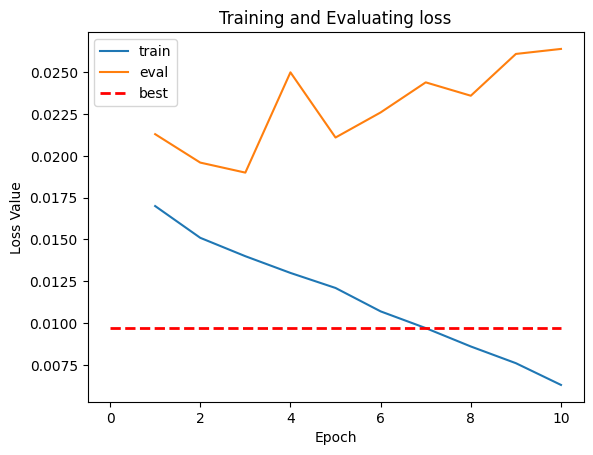

In [ ]:
plt.title("Training and Evaluating loss")
plt.plot(train_log['epoch'], train_log['loss'], label ='train')
plt.plot(eval_log['epoch'], eval_log['loss'], label ='eval')
plt.hlines(y=best_performance['loss'], xmin=0, xmax=max(train_log['epoch']),
           colors='red', linestyles='--', lw=2, label='best')

plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.show()

draw the acc curve

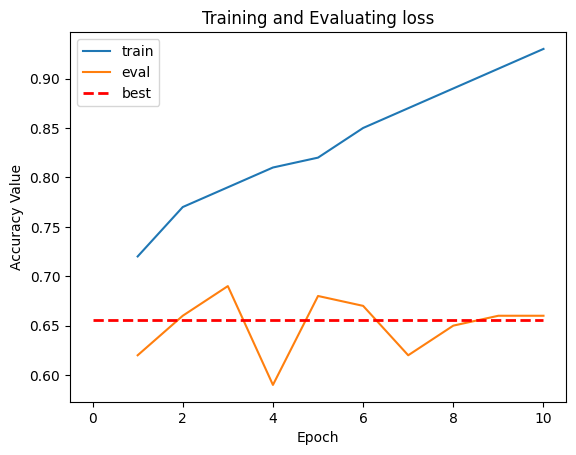

In [ ]:
plt.title("Training and Evaluating loss")
plt.plot(train_log['epoch'], train_log['acc'], label ='train')
plt.plot(eval_log['epoch'], eval_log['acc'], label ='eval')
plt.hlines(y=best_performance['acc'], xmin=0, xmax=max(train_log['epoch']),
           colors='red', linestyles='--', lw=2, label='best')

plt.xlabel("Epoch")
plt.ylabel("Accuracy Value")
plt.legend()
plt.show()

draw the auroc curve

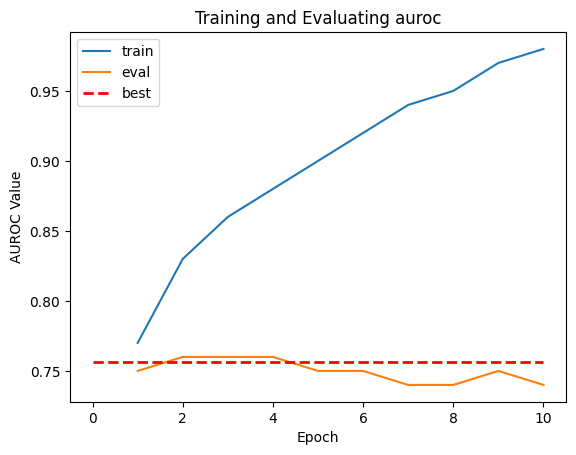

In [ ]:
plt.title("Training and Evaluating auroc")
plt.plot(train_log['epoch'], train_log['auroc'], label ='train')
plt.plot(eval_log['epoch'], eval_log['auroc'], label ='eval')
plt.hlines(y=best_performance['auroc'], xmin=0, xmax=max(train_log['epoch']),
           colors='red', linestyles='--', lw=2, label='best')

plt.xlabel("Epoch")
plt.ylabel("AUROC Value")
plt.legend()
plt.show()

類別表現分析

In [ ]:
model.to(learn_args["device"])
model.eval()
train_count = {
    "hateful": [0, 0], "nothateful": [0, 0]
}
eval_count = {
    "hateful": [0, 0], "nothateful": [0, 0]
}
train_error_cases = []
eval_error_cases = []

for batch in tqdm(train_loader):
    batch = {
        k: v.to(learn_args["device"]) for k, v in batch.items()
    }
    outputs = model(batch)
    pred = torch.argmax(outputs, dim=-1).detach().cpu()
    target = batch['label'].detach().cpu()

    train_count["nothateful"][1] += len(target[target == 0])
    train_count["nothateful"][0] += len(pred[target==0][pred[target==0]==0])
    train_count["hateful"][1] += len(target[target == 1])
    train_count["hateful"][0] += len(pred[target==1][pred[target==1]==1])

    train_error_cases.append(
        batch["id"].detach().cpu()[pred != target]
    )

for batch in tqdm(dev_loader):
    batch = {
        k: v.to(learn_args["device"]) for k, v in batch.items()
    }
    outputs = model(batch)
    pred = torch.argmax(outputs, dim=-1).detach().cpu()
    target = batch['label'].detach().cpu()

    eval_count["nothateful"][1] += len(target[target == 0])
    eval_count["nothateful"][0] += len(pred[target==0][pred[target==0]==0])
    eval_count["hateful"][1] += len(target[target == 1])
    eval_count["hateful"][0] += len(pred[target==1][pred[target==1]==1])

    batch["id"].detach().cpu()[pred != target]
    train_error_cases.append(
        batch["id"].detach().cpu()[pred != target]
    )

  0%|          | 0/133 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

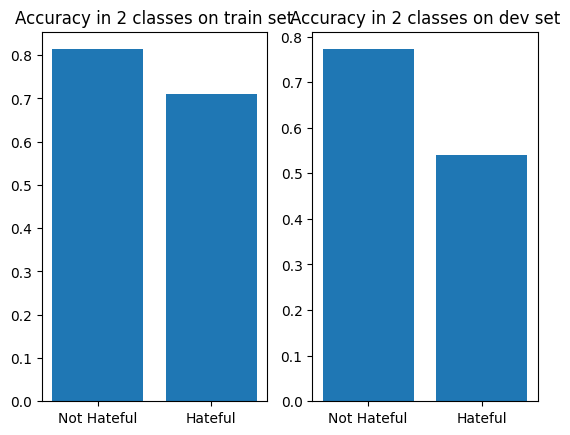

In [ ]:
plt.subplot(121)
plt.title("Accuracy in 2 classes on train set")
plt.bar(
    ["Not Hateful", "Hateful"],
    [train_count["nothateful"][0]/train_count["nothateful"][1],
    train_count["hateful"][0]/train_count["hateful"][1]]
)

plt.subplot(122)
plt.title("Accuracy in 2 classes on dev set")
plt.bar(
    ["Not Hateful", "Hateful"],
    [eval_count["nothateful"][0]/eval_count["nothateful"][1],
    eval_count["hateful"][0]/eval_count["hateful"][1]]
)
plt.tightlayout()
plt.show()

### 小結論
* 訓練過程很快就overfitting
* 對於concat fusion模型來說，hateful確實如我預期的表現會較差，通常hateful需要額外的知識來推理

### 錯誤案例分析

儲存成 id " " 形式

In [ ]:
split_idx = 8
with open("error_analysis.txt", "w") as f:
    f.write("Train ")
    data = []
    for ids in train_error_cases[:-split_idx]:
        data.extend(ids.tolist())
    data = [str(value) for value in data]
    f.write(" ".join(data))
    f.write("\n")
    f.write("Eval ")
    data = []
    for ids in train_error_cases[-split_idx:]:
        data.extend(ids.tolist())
    data = [str(value) for value in data]
    f.write(" ".join(data))

讀取 annotations

In [ ]:
TRAIN_ANNOTATION = "train.json"
TEST_ANNOTATION = "train.json"
DEVSEEN_ANNOTATION = "dev_seen.json"
DEVUNSEEN_ANNOTATION = "dev_unseen.json"
ENTRY = os.path.join("data", "annotations")

train_path = os.path.join(ENTRY, TRAIN_ANNOTATION)
test_path = os.path.join(ENTRY, TEST_ANNOTATION)
# 結果在seen裡面
dev_seen_path = os.path.join(ENTRY, DEVSEEN_ANNOTATION)
dev_unseen_path = os.path.join(ENTRY, DEVUNSEEN_ANNOTATION)

In [ ]:
df = pd.read_json(dev_seen_path, lines=True)
df.head()

,id,set_name,img,text,gold_hate,gold_pc,gold_attack,pc,attack
0,5349,dev_seen,img/05349.png,normal day in a islamic country,[not_hateful],[pc_empty],[attack_empty],None,None
1,17265,dev_seen,img/17265.png,meanwhile in baltimore,[not_hateful],[pc_empty],[attack_empty],None,None
2,91405,dev_seen,img/91405.png,wears rag on her head so her brother husband d...,[not_hateful],[pc_empty],[attack_empty],None,None
3,83497,dev_seen,img/83497.png,different types of radicalization,[not_hateful],[pc_empty],[attack_empty],None,None
4,4569,dev_seen,img/04569.png,when is the time to eat i am hungry,[not_hateful],[pc_empty],[attack_empty],None,None


In [ ]:
import os
data = []
with open("error_analysis.txt", "r") as f:
    for i, line in enumerate(f.readlines()):
        if i == 1:
            line = line.rstrip()
            line = line.split()[1:]
            line = [int(v) for v in line]
            data.extend(line)

In [ ]:
data = set(data)
error_dict = {
    "pc": {
        "pc_empty": [],
        "religion": [],
        "race": [],
        "sex": [],
        "nationality": [],
        "disability": []
    },
    "attack": {
        "attack_empty": [],
        "mocking": [],
        "dehumanizing": [],
        "slurs": [],
        "inciting_violence": [],
        "contempt": [],
        "inferiority": [],
        "exclusion": []
    }
}
for _, row in df.iterrows():

    if row["id"] in data:
        for k in error_dict["pc"].keys():
            error_dict["pc"][k].append(0)
        for k in error_dict["attack"].keys():
            error_dict["attack"][k].append(0)
        for pc in row["gold_pc"]:
            error_dict["pc"][pc][-1] = 1
        for attack in row["gold_attack"]:
            error_dict["attack"][attack][-1] = 1

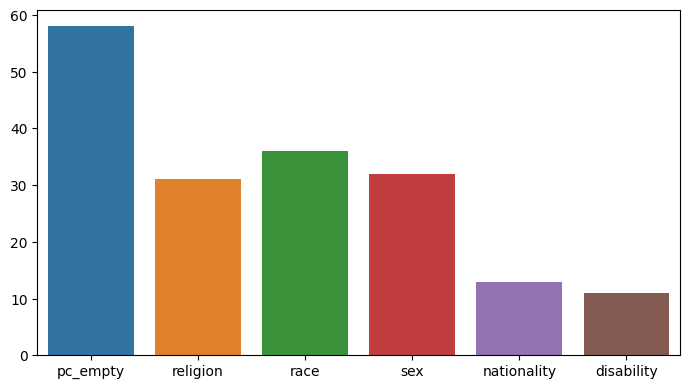

In [ ]:
import seaborn as sns
plt.figure(figsize=(7, 4))
sns.barplot(x=list(error_dict["pc"].keys()), y=[sum(v) for v in error_dict["pc"].values()])
plt.tight_layout()
plt.show()